In [38]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_data_folder = Path(r"D:\coding\Jupyter_notebooks\ML\credit_risk_data")
path_train = path_data_folder / "application_train.csv"
path_test = path_data_folder / "application_test.csv"
path_col_description = path_data_folder / "HomeCredit_columns_description.csv"

In [3]:
data_original = pd.read_csv(path_train)

In [9]:
# create sklearn data pipeline using EDA results

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline


class PrimaryTransformer(TransformerMixin, BaseEstimator):
    unnecessary_columns = ["SK_ID_CURR","NAME_TYPE_SUITE","DAYS_BIRTH","DAYS_EMPLOYED","DAYS_REGISTRATION","DAYS_ID_PUBLISH","WEEKDAY_APPR_PROCESS_START","HOUR_APPR_PROCESS_START","REGION_RATING_CLIENT","DAYS_LAST_PHONE_CHANGE","OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE","OBS_60_CNT_SOCIAL_CIRCLE","FLAG_MOBIL","FLAG_EMP_PHONE","FLAG_WORK_PHONE","FLAG_PHONE","FLAG_EMAIL","FLAG_CONT_MOBILE"]
    feat_categorical = {"TARGET", "NAME_CONTRACT_TYPE",  "CODE_GENDER",  "FLAG_OWN_CAR",  "FLAG_OWN_REALTY",  "NAME_INCOME_TYPE",  "NAME_EDUCATION_TYPE",  "NAME_FAMILY_STATUS",  "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "REGION_RATING_CLIENT_W_CITY", "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY", "ORGANIZATION_TYPE"}
    feat_high_correlating = ["CNT_CHILDREN", "AMT_GOODS_PRICE", "AMT_ANNUITY"]
    
    def transform(self, X, **transform_params):
        X.drop(columns=self.unnecessary_columns, inplace=True)
        X.drop(columns=self.feat_high_correlating, inplace=True)
        X.drop(columns=[i for i in X.columns if i.startswith("FLAG_DOCUMENT_")], inplace=True)
        
        for feature in self.feat_categorical:
            X[feature] = X[feature].astype("category")
        return X


class DropExternalSourcesColumns(BaseEstimator, TransformerMixin):

    def transform(self, X, **params):
        X.drop(columns=[col for col in X.columns if col.startswith("EXT_SOURCE_")], inplace=True)
        return X


class RequestsColumnTransformer(BaseEstimator, TransformerMixin):
    requests_columns = ["AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY","AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"]
    new_requests_col = "AMT_REQ_CREDIT_BUREAU"

    def transform(self, df, **transform_params):
        df["AMT_REQ_CREDIT_BUREAU"] = np.sum(df[self.requests_columns], axis=1)
        df.drop(columns=self.requests_columns, inplace=True)
        return df


class BuildingColumnsTransformer(BaseEstimator, TransformerMixin):
    building_columns = ["APARTMENTS_AVG","BASEMENTAREA_AVG","YEARS_BEGINEXPLUATATION_AVG","YEARS_BUILD_AVG","COMMONAREA_AVG","ELEVATORS_AVG","ENTRANCES_AVG","FLOORSMAX_AVG","FLOORSMIN_AVG","LANDAREA_AVG","LIVINGAPARTMENTS_AVG","LIVINGAREA_AVG","NONLIVINGAPARTMENTS_AVG","NONLIVINGAREA_AVG","APARTMENTS_MODE","BASEMENTAREA_MODE","YEARS_BEGINEXPLUATATION_MODE","YEARS_BUILD_MODE","COMMONAREA_MODE","ELEVATORS_MODE","ENTRANCES_MODE","FLOORSMAX_MODE","FLOORSMIN_MODE","LANDAREA_MODE","LIVINGAPARTMENTS_MODE","LIVINGAREA_MODE","NONLIVINGAPARTMENTS_MODE","NONLIVINGAREA_MODE","APARTMENTS_MEDI","BASEMENTAREA_MEDI","YEARS_BEGINEXPLUATATION_MEDI","YEARS_BUILD_MEDI","COMMONAREA_MEDI","ELEVATORS_MEDI","ENTRANCES_MEDI","FLOORSMAX_MEDI","FLOORSMIN_MEDI","LANDAREA_MEDI","LIVINGAPARTMENTS_MEDI","LIVINGAREA_MEDI","NONLIVINGAPARTMENTS_MEDI","NONLIVINGAREA_MEDI","FONDKAPREMONT_MODE","HOUSETYPE_MODE","TOTALAREA_MODE","WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE"]

    def transform(self, df, **params):
        df["BUILDING_INFO_AVAILABLE"] = ~df[self.building_columns].isnull().any(axis=1)
        df.drop(columns=self.building_columns, inplace=True)
        return df


class CarOwnAgeTransformer(BaseEstimator, TransformerMixin):
    flag_own_car = "FLAG_OWN_CAR"
    own_car_age = "OWN_CAR_AGE"

    def transform(self, df, **params):
        df[self.flag_own_car] = ~df[self.own_car_age].isnull()
        df[self.flag_own_car] = df[self.flag_own_car].astype("int8")
        df.drop(columns=[self.own_car_age], inplace=True)
        return df

class DropOutliers(BaseEstimator, TransformerMixin):

    def transform(self, df, **params):
        df.drop(index=np.where(df["AMT_INCOME_TOTAL"] > 2.025e+05)[0], inplace=True)
        df.drop(index=np.where(df["CODE_GENDER"] == "XNA")[0], inplace=True)
        return df

    def fit(self, X, y=None, **fit_params):
        return self


class EncodeBinaryCategoricalValues(BaseEstimator, TransformerMixin):

    def transform(self, df, **params):
        categorical_features = df.select_dtypes("category")

        for feature in categorical_features.columns:
            if len(df[feature].unique()) == 2:
                df[feature] = df[feature].cat.codes
        return df


class EncodeOtherCategoricalValues(BaseEstimator, TransformerMixin):

    def transform(self, df: pd.DataFrame, **params):
        categorical_features = df.select_dtypes("category")
        dummies = pd.get_dummies(categorical_features)
        return pd.concat([df.drop(columns=categorical_features.columns), dummies], axis=1)

    def fit(self, df, y=None, **params):
        return self


data_prepare_pipeline = make_pipeline(
    PrimaryTransformer(),
    DropExternalSourcesColumns(),
    CarOwnAgeTransformer(),
    RequestsColumnTransformer(),
    BuildingColumnsTransformer(),
    DropOutliers(),
    'passthrough'
)

data_train_pipeline = make_pipeline(
    data_prepare_pipeline,
    EncodeBinaryCategoricalValues(),
    EncodeOtherCategoricalValues()
)

In [ ]:
data = data_prepare_pipeline.transform(data_original.copy(deep=True))

In [50]:
data.describe(include="all")

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,CNT_FAM_MEMBERS,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
count,235973.000000,235973.000000,235973.000000,235973.000000,235973.000000,2.359730e+05,235973.000000,235972.000000,235973.000000,235973.000000,...,235973.000000,235973.000000,235973.000000,235973.000000,235973.000000,235973.000000,235973.000000,235973.000000,235973.000000,235973.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.084255,0.098032,0.294941,0.692850,129582.587567,5.275367e+05,0.019646,2.137673,0.010590,0.033957,...,0.000178,0.000157,0.001941,0.025736,0.000585,0.007073,0.003801,0.015434,0.003924,0.203523
std,0.277771,0.297359,0.456017,0.461313,41057.017525,3.485555e+05,0.011899,0.910635,0.102363,0.181120,...,0.013340,0.012521,0.044013,0.158347,0.024176,0.083802,0.061537,0.123271,0.062520,0.402619
min,0.000000,0.000000,0.000000,0.000000,25650.000000,4.500000e+04,0.000290,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,94500.000000,2.547000e+05,0.010006,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,135000.000000,4.500000e+05,0.018850,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,157500.000000,7.239960e+05,0.026392,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='CODE_GENDER', ylabel='count'>

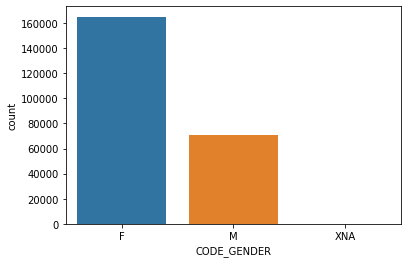

In [9]:
sns.countplot(x="CODE_GENDER", data=data)

In [18]:
np.where(data["CODE_GENDER"] == "XNA")

(array([29611, 64072], dtype=int64),)

<AxesSubplot:xlabel='TARGET', ylabel='count'>

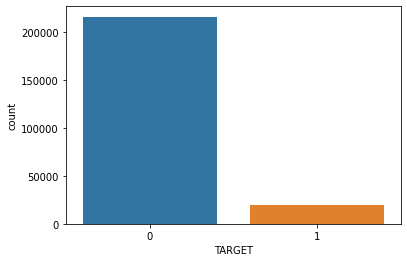

In [52]:
sns.countplot(x="TARGET", data=data)

<AxesSubplot:xlabel='AMT_INCOME_TOTAL'>

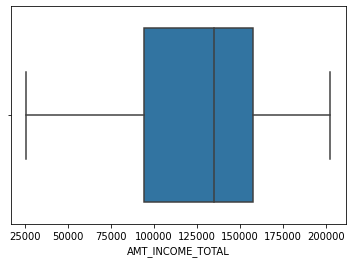

In [20]:
feat_income_total = "AMT_INCOME_TOTAL"
sns.boxplot(x=feat_income_total, data=data)

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

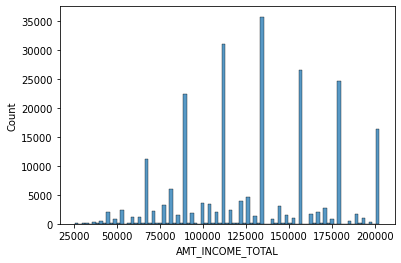

In [42]:
# maybe create clusterizer for total income
sns.histplot(x=feat_income_total, data=data)

In [60]:
counts, bins = np.histogram(data[feat_income_total], 1000)
print(sorted(list(zip(counts, bins)), key=lambda x: x[0], reverse=True)[:10])

[(35752, 134943.3), (31023, 112483.34999999999), (26558, 157403.25), (24719, 179863.19999999998), (22489, 89846.54999999999), (16341, 202323.15), (11147, 67386.6), (6001, 80827.2), (4669, 125923.95), (3851, 121325.84999999999)]


In [ ]:
sns.violinplot(x=feat_income_total, data=data)

In [37]:
data[feat_income_total].describe()

count    235973.000000
mean     129582.587567
std       41057.017525
min       25650.000000
25%       94500.000000
50%      135000.000000
75%      157500.000000
max      202500.000000
Name: AMT_INCOME_TOTAL, dtype: float64

In [ ]:
data = None

In [10]:
data_train = data_train_pipeline.transform(data_original.copy(deep=True))

In [51]:
y_columns = ["TARGET"]
x_data, y_data = data_train[data_train.columns.difference(y_columns)], data_train[y_columns]
x_data = x_data.astype("float32")
y_data = y_data.astype("float32")

<AxesSubplot:ylabel='Count'>

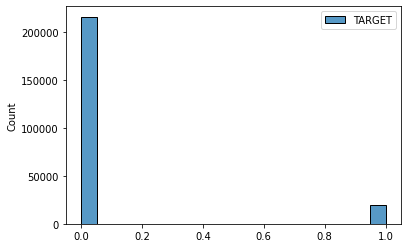

In [33]:
sns.histplot(data=y_data)

In [72]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(len(x_data.columns),), name="input")
layer1 = layers.Dense(50, activation="linear", name="dense_1")(inputs)
output = layers.Dense(1, activation="sigmoid", name="output")(layer1)

model = keras.Model(inputs=inputs, outputs=output)
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [74]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 123)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6200      
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 6,251
Trainable params: 6,251
Non-trainable params: 0
_________________________________________________________________


In [55]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20)

In [71]:
history = model.fit(x_train, y_train, 500, 1, validation_split=0.1)

340/340 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.9168 - val_loss: nan - val_accuracy: 0.9162

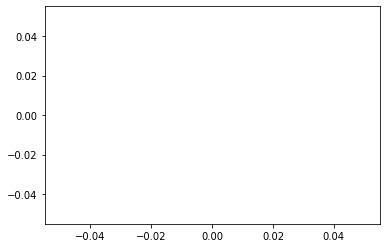

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [40]:
history.history

{'loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'binary_accuracy': [0.907962441444397,
  0.9151431918144226,
  0.9151431918144226,
  0.9151431918144226,
  0.9151431918144226,
  0.9151431918144226,
  0.9151431918144226,
  0.9151431918144226,
  0.9151431918144226,
  0.9151431918144226],
 'val_loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'val_binary_accuracy': [0.9179468154907227,
  0.9179468154907227,
  0.9179468154907227,
  0.9179468154907227,
  0.9179468154907227,
  0.9179468154907227,
  0.9179468154907227,
  0.9179468154907227,
  0.9179468154907227,
  0.9179468154907227]}